 ### Python scripts used for the paper entitled:
 #### Single character insertion-deletion model preserves long indels in ancestral sequence reconstruction

In [7]:
## Python 3
# Indel Pattern Plots for Mammalian Data
# Created by:  Gholamhossein Jowkar <jowk@zhaw.ch>
# ACGT ZHAW
# Created date: Nov 2023
# Modified by: jowk
# Modified date: 


In [10]:
import os, sys, time, statistics, json, re, fnmatch
from collections import Counter
from statistics import mean

from Bio import AlignIO, SeqIO
from Bio.Align import MultipleSeqAlignment

from ete3 import Tree

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, auc

path = "./" #path to the data directory
os.chdir(path)

# Setting the styles for plots
sns.set_style('white')
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_style('white')
sns.set_context("paper", font_scale = 1)
color_1 = sns.color_palette()[0]
color_2 = sns.color_palette()[1]

## Summary statistics

In [3]:
# Load the data
w_df = pd.read_csv("01_summary_stat_global_df.csv")
spc_df = pd.read_csv("01_summary_stat_spc_df.csv")
with open('01_dic_global_gap_len_pr_sp.txt') as fl:
    len_data = json.load(fl)

#### The summary statistics extracted from the data set per OMA group:
    The dimension of data is 12022*28 

In [4]:
w_df.head()

,OMA_group,aln_len,total_gap_count,msa_gap_count,asr_gap_count,min_gap_count,spc_wmin_gap_count,max_gap_count,spc_wmax_gap_count,gap_ratio,...,num_ins,num_del,indel_ratio,is_gappy,mu,lambda,loglikelihood,intensity,expected_len,tree_len
0,301559,296,302,177,125,24,Gorilla,43,Rattus,0.092752,...,43,52,1.209302,1,59.429600,1415.1500,-3240.81,23.812208,84101.798440,0.01269
1,302161,1078,1747,981,766,115,Homo,241,Macaca,0.147327,...,272,215,0.790441,1,13.940800,1340.8400,-11874.30,96.180994,18692.382270,0.04878
2,807362,1093,13,7,6,0,Pan,4,Rattus,0.001081,...,4,1,0.250000,1,0.011001,11.9889,-9442.28,1089.781115,0.131892,0.17093
3,807365,638,8,4,4,0,Pan,2,Mus,0.001140,...,2,0,0.000000,1,0.074245,47.1929,-3738.94,635.636560,3.503842,0.03370
4,807370,510,983,499,484,57,Mus,115,root,0.175223,...,130,15,0.115385,1,1.585680,543.5050,-4404.47,342.758312,861.825008,0.33634


#### The summary statistics extracted from the data set per species:
    The dimension of data is 11*9 

In [5]:
display(spc_df)

,species,number_insertion,number_deletion,number_gap,avg_gap_len,min_gap_len,max_gap_len,Genera,numb_gap_len
0,Mouse,25067,30165,357149,9.711205,1,567,Mus musculus,36777
1,Rat,48601,119929,423379,11.248114,1,1664,Rattus norvegicus,37640
2,Chimp,32083,175589,456638,14.747860,1,784,Pan troglodytes,30936
3,Human,16907,20465,316690,10.557037,1,534,Homo sapiens,29998
4,Gorilla,90145,220987,438990,15.183661,1,1082,Gorilla gorilla gorilla,28912
5,Macaque,31389,191131,480478,15.318922,1,966,Macaca fascicularis,31365
6,Murinae,22767,17246,352125,9.396013,1,567,Murinae,37476
7,Hominini,3684,8668,313132,10.452367,1,567,Hominini,29958
8,Homininae,19229,6641,308148,10.283598,1,567,Homininae,29965
9,Catarrhini,67700,30864,320782,10.418044,1,567,Catarrhini,30791


In [7]:
spc_df['indel_bias'] = spc_df['number_insertion']/spc_df['number_deletion']
spc_df

,species,number_insertion,number_deletion,number_gap,avg_gap_len,min_gap_len,max_gap_len,Genera,numb_gap_len,indel_bias
0,Mouse,25067,30165,357149,9.711205,1,567,Mus musculus,36777,0.830996
1,Rat,48601,119929,423379,11.248114,1,1664,Rattus norvegicus,37640,0.405248
2,Chimp,32083,175589,456638,14.747860,1,784,Pan troglodytes,30936,0.182716
3,Human,16907,20465,316690,10.557037,1,534,Homo sapiens,29998,0.826142
4,Gorilla,90145,220987,438990,15.183661,1,1082,Gorilla gorilla gorilla,28912,0.407920
5,Macaque,31389,191131,480478,15.318922,1,966,Macaca fascicularis,31365,0.164228
6,Murinae,22767,17246,352125,9.396013,1,567,Murinae,37476,1.320132
7,Hominini,3684,8668,313132,10.452367,1,567,Hominini,29958,0.425012
8,Homininae,19229,6641,308148,10.283598,1,567,Homininae,29965,2.895498
9,Catarrhini,67700,30864,320782,10.418044,1,567,Catarrhini,30791,2.193494


### The summary statistics of indel events

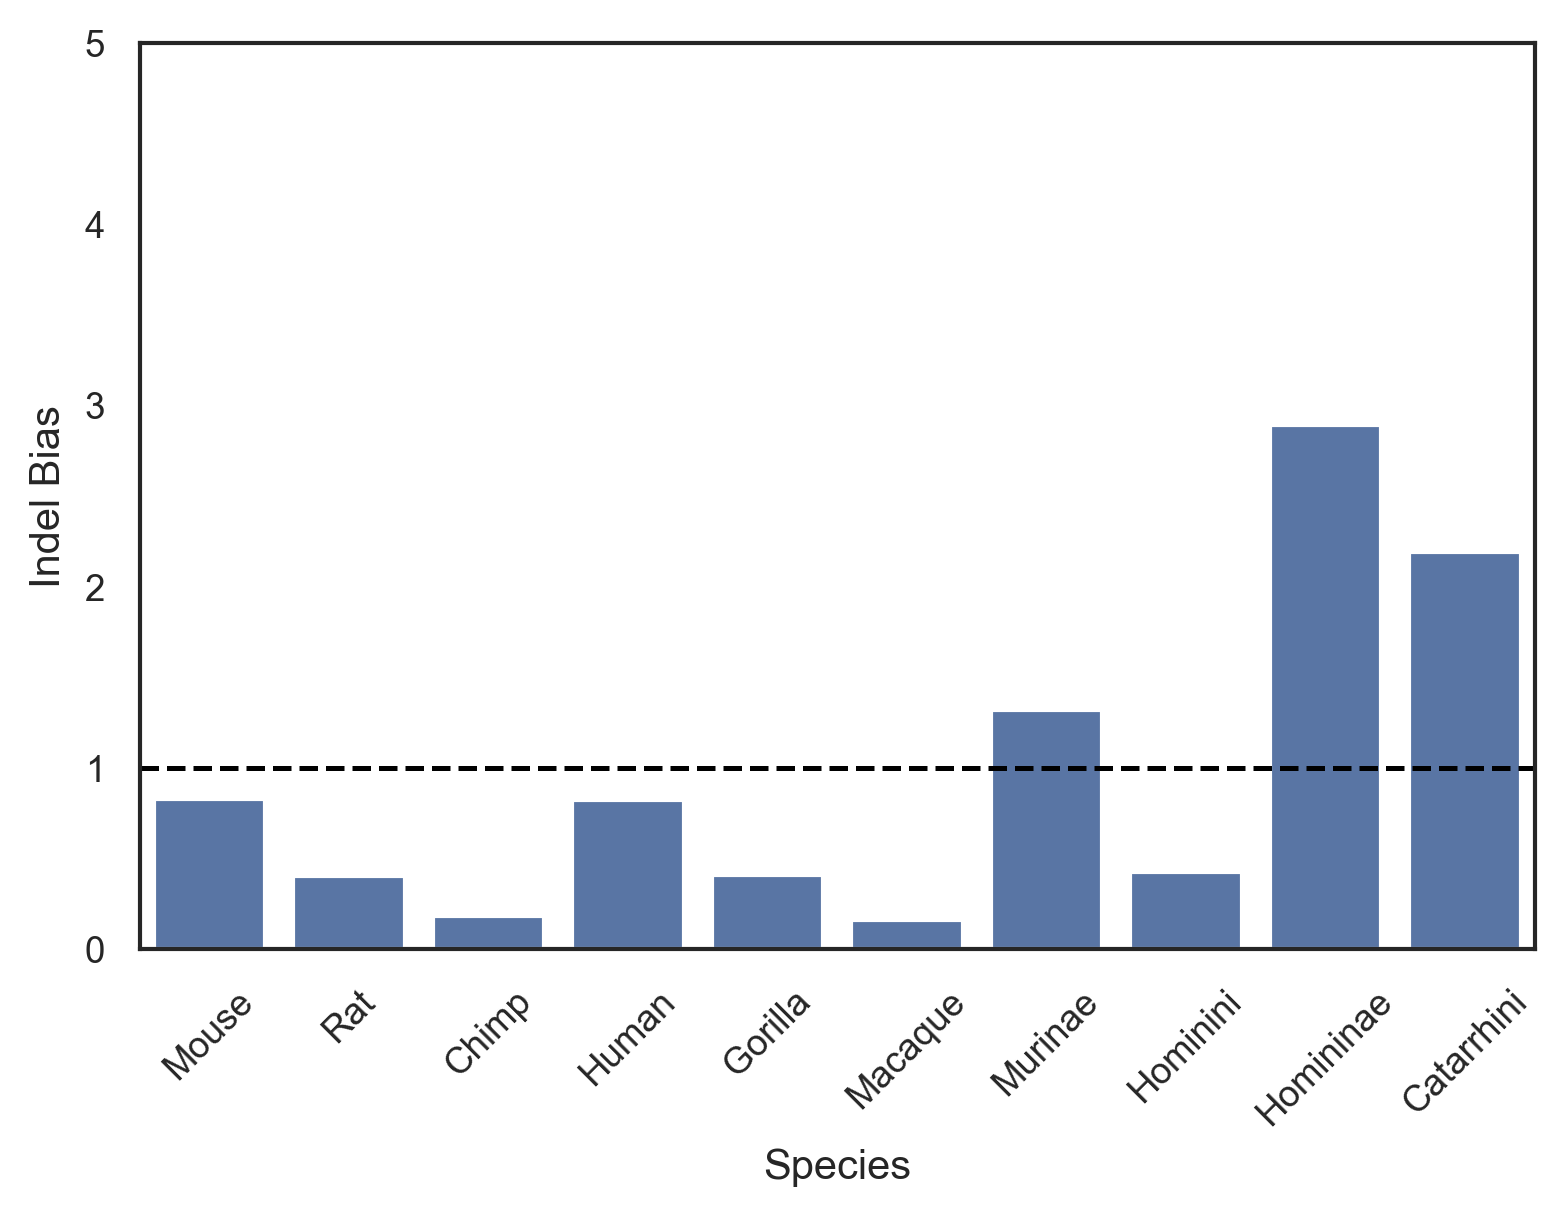

In [8]:
ax = sns.barplot(data=spc_df[:-1], x='species', y='indel_bias', color=color_1,  lw=1, dodge=True)
ax.axhline(y=1, ls='--', color='black')
ax.set(xlabel=None, ylabel=None)
ax.set(ylim=[0,5])
ax.set_ylabel(ylabel='Indel Bias',fontsize=10)
ax.set_xlabel('Species', fontsize=10)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.show()

#### Insertion-deletion events

Text(0.5, 0, 'Species')

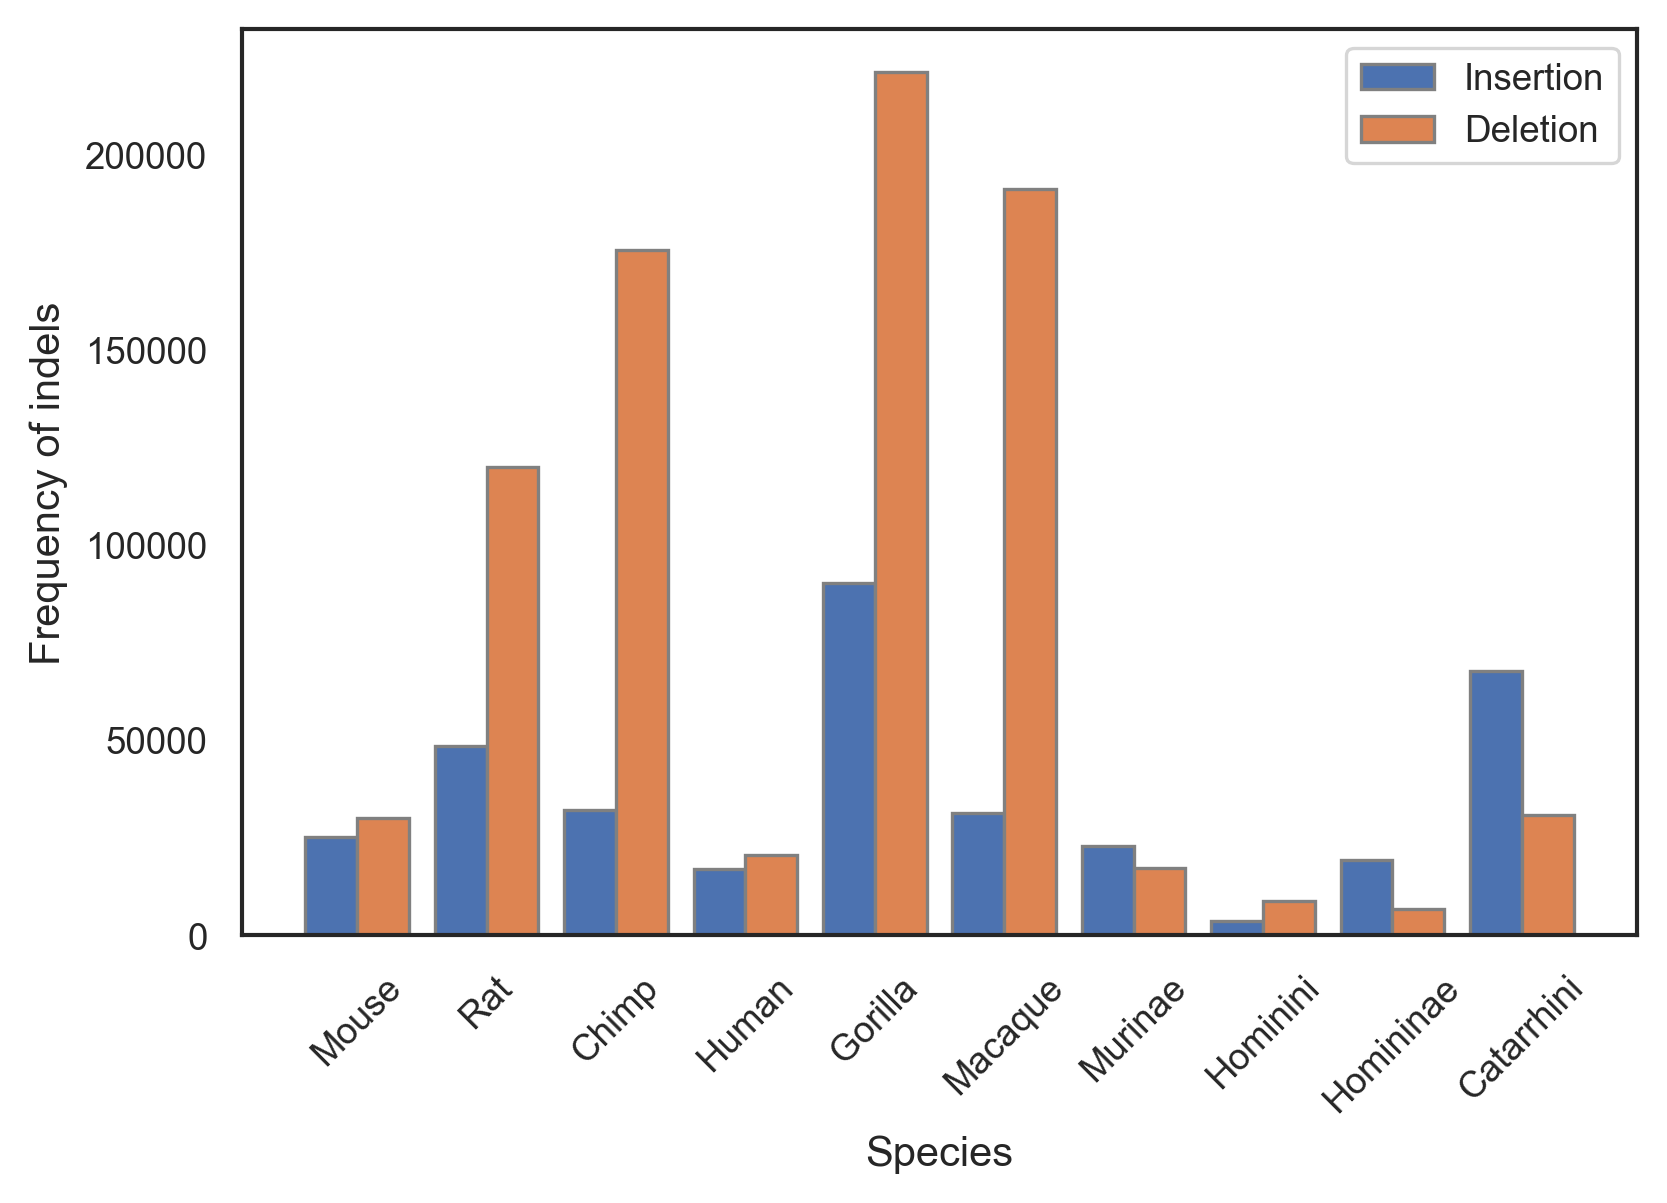

In [26]:
sns.set_style('white')
sns.set_context("paper", font_scale = 1)

X_axis = np.arange(len(spc_df['species'][:-1]))
  
plt.bar(X_axis - 0.2, spc_df['number_insertion'][:-1], 0.4, label = 'Insertion', color=color_1, ec='grey')
plt.bar(X_axis + 0.2, spc_df['number_deletion'][:-1], 0.4, label = 'Deletion', color=color_2, ec='grey')
plt.xticks(X_axis, spc_df['species'][:-1])
plt.legend(loc='upper right')
ax = plt.gca()
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.ylabel("Frequency of indels", size=10)
ax.set_xlabel('Species', fontsize=10)


#### Scalled Indel events

Text(0.5, 0, 'Species')

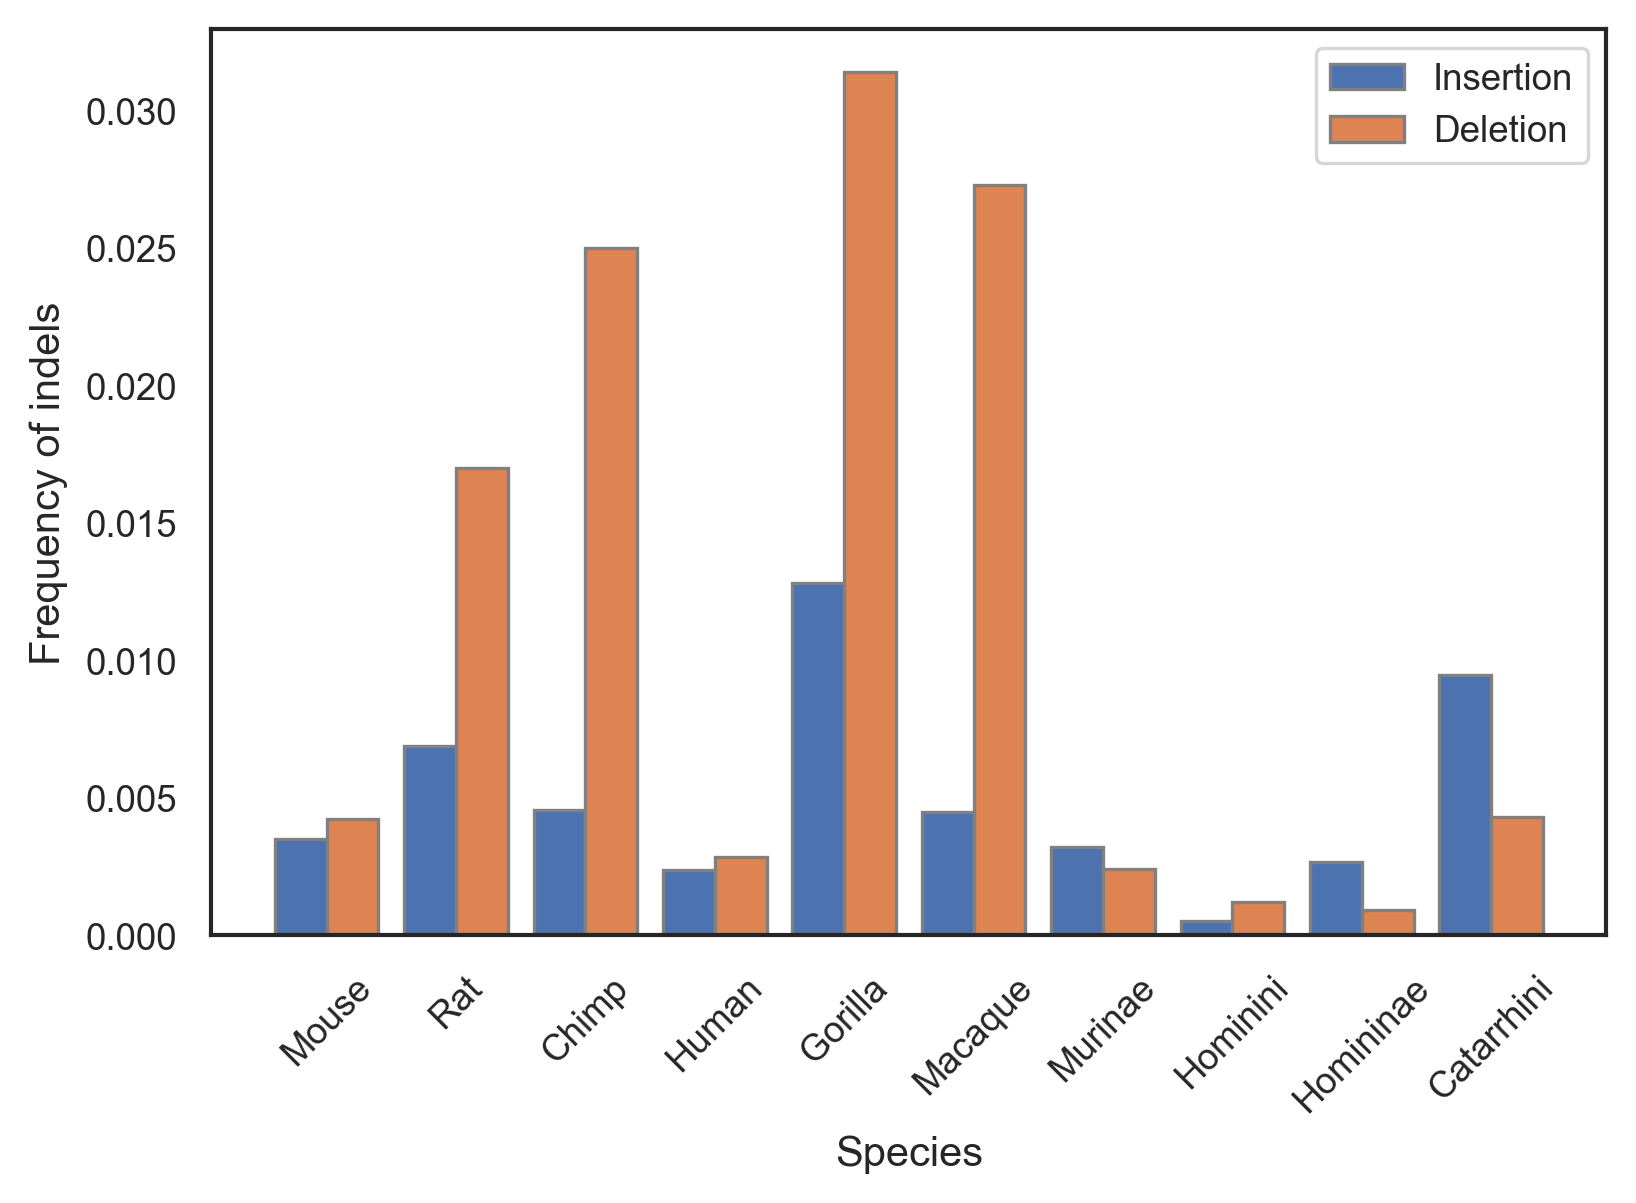

In [24]:
sns.set_style('white')
sns.set_context("paper", font_scale = 1)

spc_seq_len_df = pd.read_csv("01_gapless_total_seq_len_pr_spc.csv")

ins = spc_df['number_insertion'].div(spc_seq_len_df['Sum']) 
dele = spc_df['number_deletion'].div(spc_seq_len_df['Sum'])
X_axis = np.arange(len(spc_df['species'][:-1]))
  
plt.bar(X_axis - 0.2, ins[:-1], 0.4, label = 'Insertion', color=color_1, ec='grey')
plt.bar(X_axis + 0.2, dele[:-1], 0.4, label = 'Deletion', color=color_2, ec='grey')
plt.xticks(X_axis, spc_df['species'][:-1])
plt.legend(loc='upper right')
ax = plt.gca()
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.ylabel("Frequency of indels", size=10)
ax.set_xlabel('Species', fontsize=10)
